In [4]:
import sys
sys.path.append('/home/scc/sergio.zanotto/.local/lib/python3.10/site-packages')
sys.path.append('/home/scc/sergio.zanotto/.local/bin')

In [5]:
import pandas as pd
import numpy as np
import spacy
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize

/usr/local/jupyterhub/lib64/python3.10/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/usr/local/jupyterhub/lib64/python3.10/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


In [27]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.dpi'] = 300

##load the new calculated dataset 

In [6]:
df = pd.read_csv("Official_AivsHUman1.csv", encoding="UTF-8")

In [7]:
# Fill NaN values with the mean of the column within each group
columns_to_fill = ['t_kup', 'a_kup_ps', 'a_kup_pw', 'Syntactic_Depth']

for column in columns_to_fill:
    df[column] = df.groupby('Model')[column].transform(lambda x: x.fillna(x.mean()))

In [8]:
metadata = df.iloc[:, :5]
text_features = df.iloc[:, 5:]

In [ ]:
tx = "space"
index_list = []
for name in text_features.columns:
    if tx in name:
        index_list.append(name)
print(index_list)     

In [ ]:
# Drop these columns from the DataFrame
text_features= text_features.drop(columns=columns_to_drop)
text_features = text_features.drop(columns= ['n_space', 'n_uspace', 'a_space_ps', 'a_space_pw', 'corr_space_var', 'root_space_var', 'simp_space_var'])

In [9]:
#scale features
scaler = StandardScaler()
text_features_scaled = scaler.fit_transform(text_features) 

In [10]:
# Apply PCA
pca = PCA(n_components=2)
text_features_pca = pca.fit_transform(text_features_scaled)

In [11]:
# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
component_1_variance = explained_variance[0]
component_2_variance = explained_variance[1]

# Print the explained variance
print(f"Variance explained by Component 1: {component_1_variance * 100:.2f}%")
print(f"Variance explained by Component 2: {component_2_variance * 100:.2f}%")

Variance explained by Component 1: 18.12%
Variance explained by Component 2: 8.67%


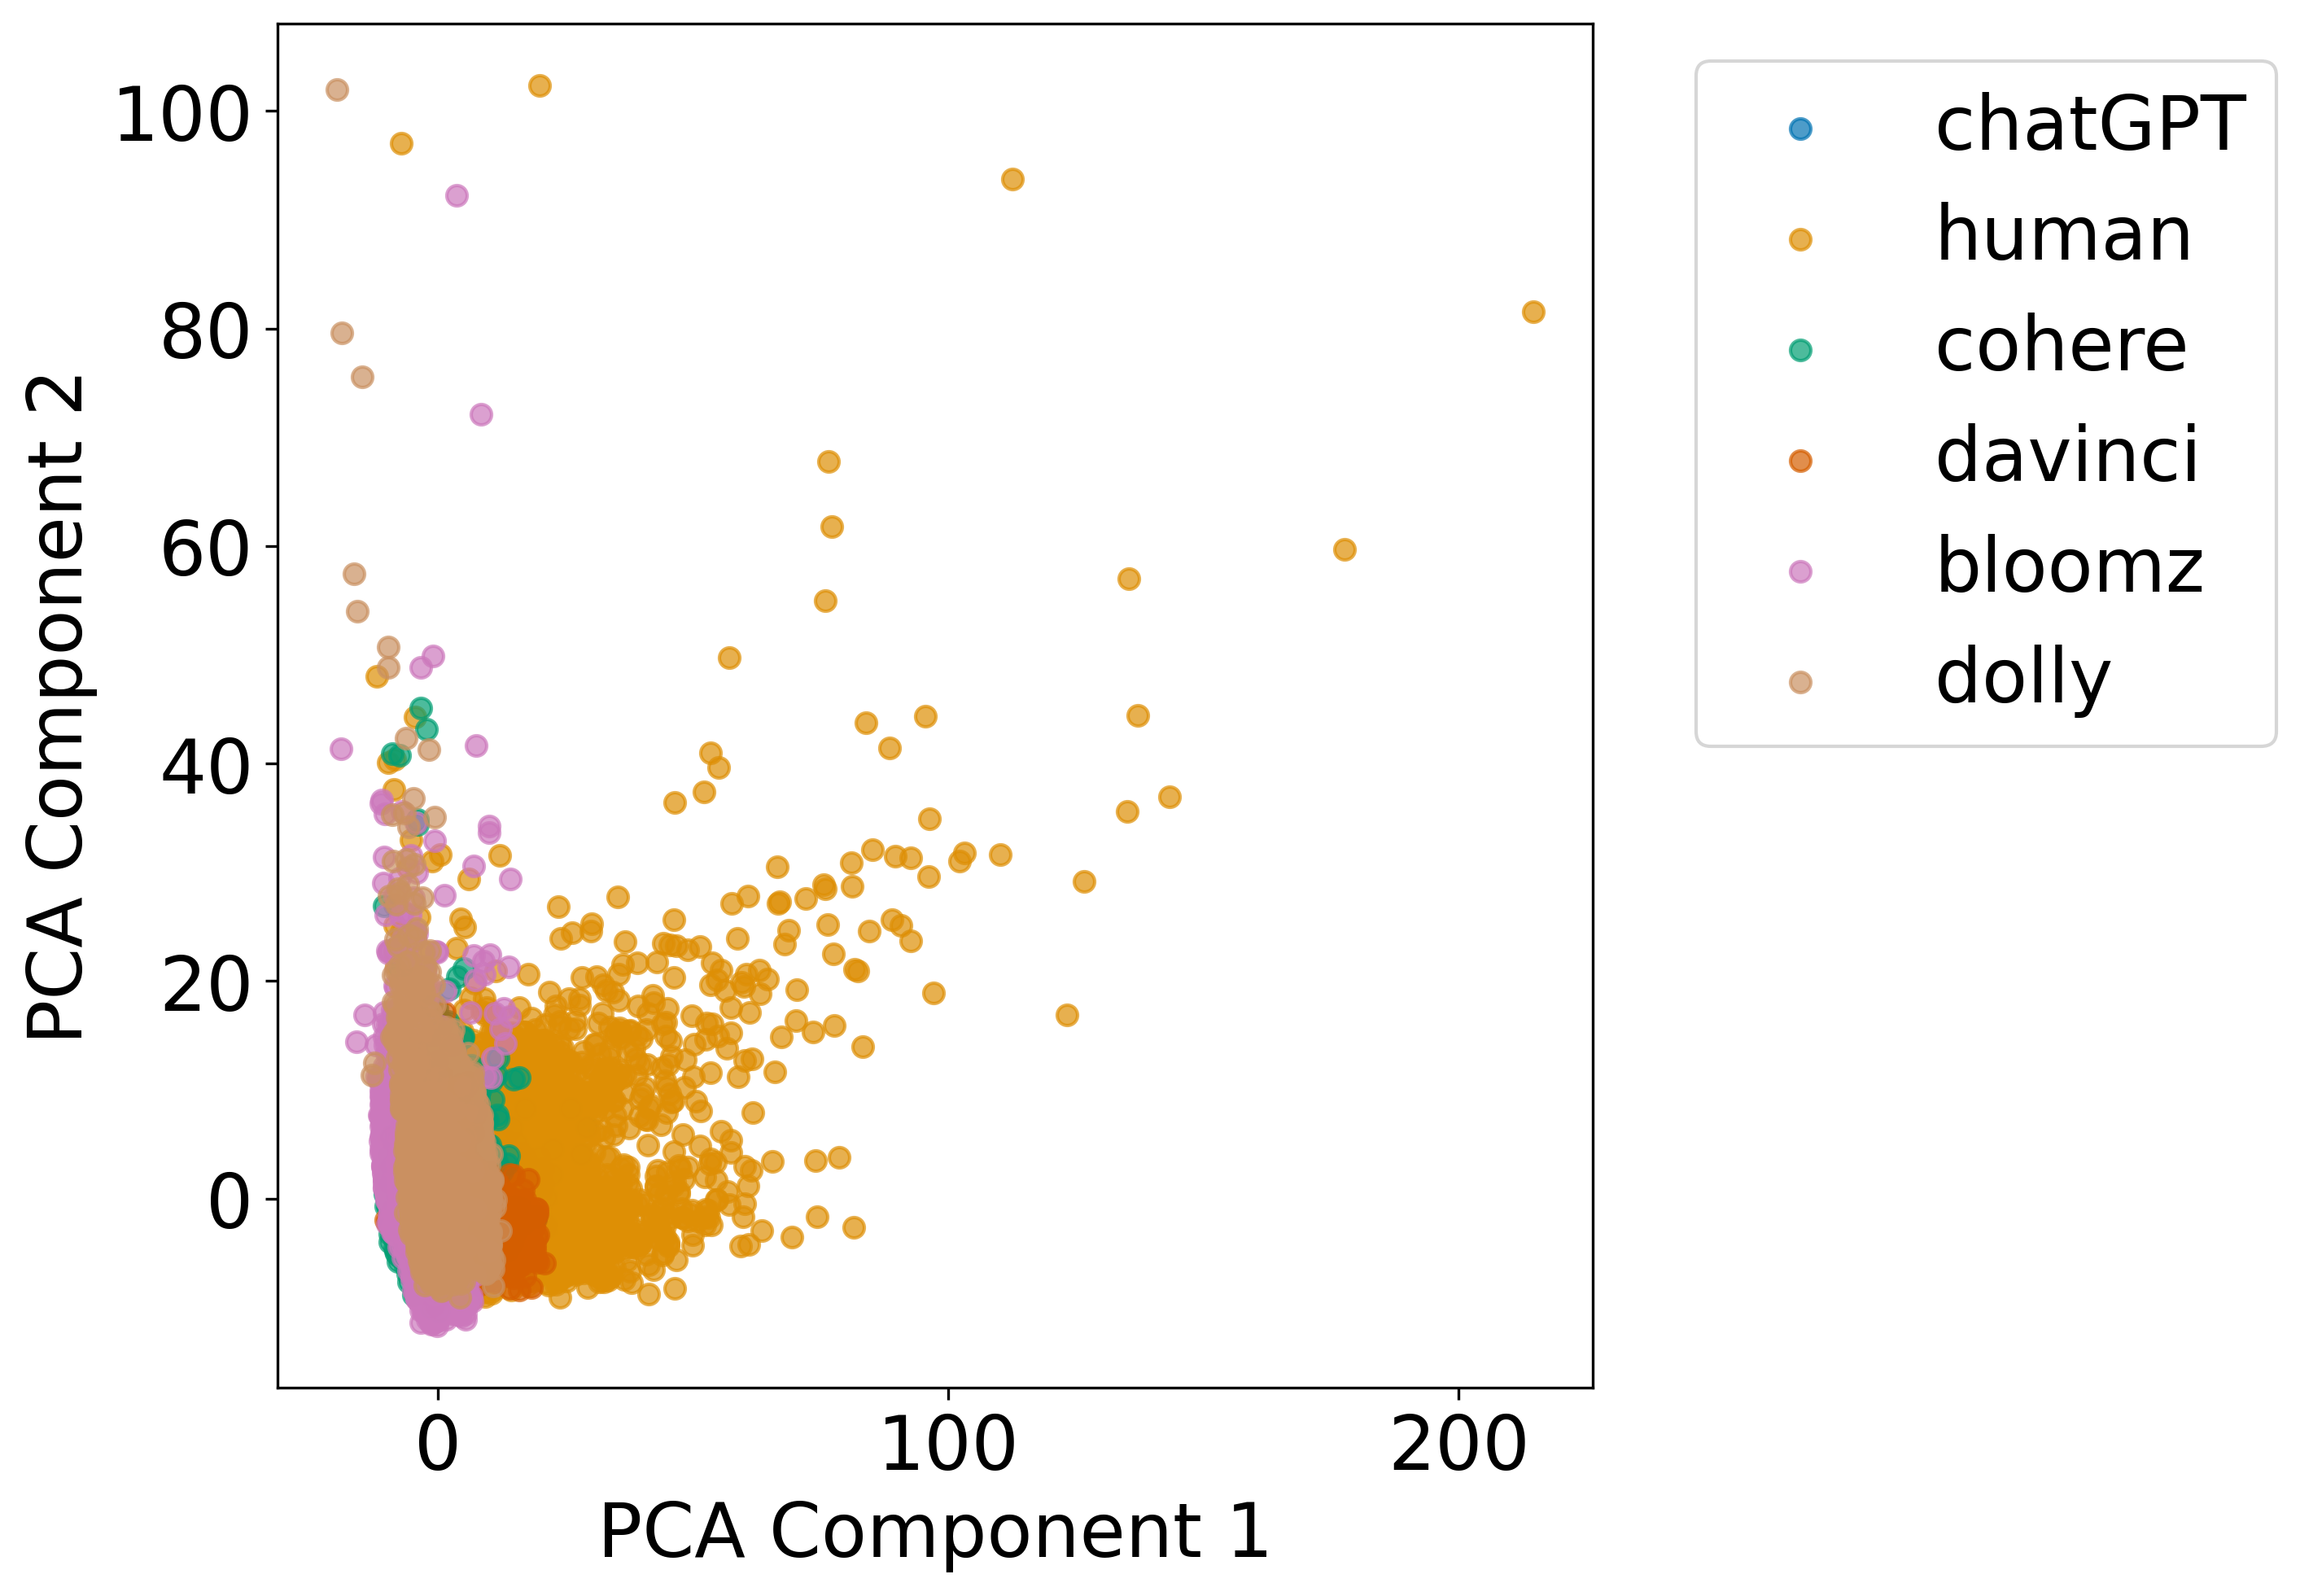

In [28]:
# Define model order and use a colorblind-friendly palette
model_order = ['chatGPT', 'human', 'cohere', 'davinci', 'bloomz', 'dolly']
colorblind_palette = sns.color_palette("colorblind", len(model_order))
model_to_color = {model: colorblind_palette[i] for i, model in enumerate(model_order)}

plt.figure(figsize=(10, 7))

# Plot PCA results considering only models
for model in model_order:
    indices = metadata['Model'] == model
    plt.scatter(
        text_features_pca[indices, 0], 
        text_features_pca[indices, 1], 
        color=model_to_color[model], 
        label=model, 
        alpha=0.7
    )

# Adjust labels and title with a larger font size
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
#plt.title('Component Reduction of Text Features by Model', fontsize=18)
#plt.xticks()
plt.yticks()

# Position the legend outside the plot and adjust its font size
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save to PDF and show the plot
plt.savefig('Text_Features_PCA.pdf')
plt.show()

In [ ]:


# Unique elements and their mappings
unique_sources = metadata['Source'].unique()
markers = ['o', 's', '^', 'P', '*', 'X']
source_to_marker = {source: markers[i] for i, source in enumerate(unique_sources)}

unique_models = metadata['Model'].unique()

plt.figure(figsize=(10, 7))

# Iterate over both models and sources to plot with color and marker variations
for model in unique_models:
    for source in unique_sources:
        indices = (metadata['Model'] == model) & (metadata['Source'] == source)
        plt.scatter(
            text_features_pca[indices, 0], 
            text_features_pca[indices, 1], 
            color=model_to_color[model], 
            marker=source_to_marker[source], 
            label=f"{model}, {source}", 
            alpha=0.7
        )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Component Reduction of Text Features by Model and Source')
plt.legend(title="Model, Source", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
# Save to PDF and close the plot
plt.savefig('Text_Features_PCA_sources.jpg')
#plt.close()


In [ ]:
# Unique elements and their mappings
unique_sources = metadata['Source'].unique()
markers = ['o', 's', '^', 'P', '*', 'X']
source_to_marker = {source: markers[i] for i, source in enumerate(unique_sources)}

unique_models = metadata['Model'].unique()


# Iterate over each source to create separate plots
for source in unique_sources:
    plt.figure(figsize=(10, 7))
    
    # Plot data for the current source
    for model in unique_models:
        indices = (metadata['Model'] == model) & (metadata['Source'] == source)
        plt.scatter(
            text_features_pca[indices, 0], 
            text_features_pca[indices, 1], 
            color=model_to_color[model], 
            marker=source_to_marker[source], 
            label=model, 
            alpha=0.7
        )
    
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'PCA of Text Features for Source: {source}')
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save each plot to a separate file
    plt.savefig(f'PCA_Text_Features_{source}.jpg')
    plt.show()
    # plt.close()

In [16]:
unique_models = df['Model'].unique()
unique_sources = df['Source'].unique()
# Calculate centroids of each model in the PCA space
model_centroids = {}
model_variances = {}

for model in unique_models:
    # Indices of rows for the current model
    indices = metadata['Model'] == model
    # Calculate centroid (mean for each dimension)
    centroid = np.mean(text_features_pca[indices, :], axis=0)
    model_centroids[model] = centroid
    
    # Calculate squared Euclidean distances of points to the centroid
    distances_squared = np.sum((text_features_pca[indices, :] - centroid) ** 2, axis=1)
    # Calculate variance (mean of squared distances)
    variance = np.mean(distances_squared)
    model_variances[model] = variance

print(model_variances)

{'chatGPT': 26.12461597432616, 'human': 173.76471788546561, 'cohere': 20.480228970105703, 'davinci': 29.516263883468742, 'bloomz': 40.9184852950416, 'dolly': 30.123820196831254}


In [17]:
# Initialize dictionaries to store centroids and variances for each model-source combination
model_source_centroids = {}
model_source_variances = {}

for model in unique_models:
    for source in unique_sources:
        # Indices of rows for the current model and source
        indices = (metadata['Model'] == model) & (metadata['Source'] == source)
        
        # Only proceed if there are points for this model-source combination
        if np.any(indices):
            # Calculate centroid (mean for each dimension)
            centroid = np.mean(text_features_pca[indices, :], axis=0)
            model_source_centroids[(model, source)] = centroid
            
            # Calculate squared Euclidean distances of points to the centroid
            distances_squared = np.sum((text_features_pca[indices, :] - centroid) ** 2, axis=1)
            # Calculate variance (mean of squared distances)
            variance = np.mean(distances_squared)
            model_source_variances[(model, source)] = variance

# Printing the variances for each model-source combination for inspection
for key, value in model_source_variances.items():
    print(f"{key}: {value}")

('chatGPT', 'wikihow'): 17.70729425969636
('chatGPT', 'wikipedia'): 4.72444830436462
('chatGPT', 'reddit'): 7.696939009245507
('chatGPT', 'arxiv'): 1.6392785486091306
('human', 'wikihow'): 167.20421909084766
('human', 'wikipedia'): 296.7450304239587
('human', 'reddit'): 50.66869990329252
('human', 'arxiv'): 4.700975621191739
('cohere', 'wikihow'): 13.351433378139909
('cohere', 'wikipedia'): 16.714911659698867
('cohere', 'reddit'): 12.652542612384796
('cohere', 'arxiv'): 4.302804405651111
('davinci', 'wikihow'): 23.66246628837972
('davinci', 'wikipedia'): 6.474116685551982
('davinci', 'reddit'): 6.604338770605408
('davinci', 'arxiv'): 4.186284184609008
('bloomz', 'wikihow'): 24.995484200452392
('bloomz', 'wikipedia'): 25.660583379893918
('bloomz', 'reddit'): 14.230394586395551
('bloomz', 'arxiv'): 9.743252290278392
('dolly', 'wikihow'): 33.69364504358768
('dolly', 'wikipedia'): 34.566754010950966
('dolly', 'reddit'): 12.944743227636708
('dolly', 'arxiv'): 9.104573293575466


# FAMILY OF FEATURES PCA

In [ ]:
# Load the family data
family_data = pd.read_csv('LFTK - All Linguistic Features - v.1.0.8.csv')

# Extract key and family columns
keys = family_data['key']
families = family_data['family']

# Map keys to families
key_to_family = dict(zip(keys, families))

# Group columns by family
family_columns = {}
for col in text_features.columns:
    if col in key_to_family:
        family = key_to_family[col]
        if family not in family_columns:
            family_columns[family] = []
        family_columns[family].append(col)

# Perform PCA and plot for each family
for family, columns in family_columns.items():
    # Extract the features for this family
    family_features = text_features[columns]
    
    # Perform PCA
    pca = PCA(n_components=2)
    family_features_pca = pca.fit_transform(family_features)
    
    # Create DataFrame for PCA results
    pca_df = pd.DataFrame(family_features_pca, columns=['PCA1', 'PCA2'])
    pca_df['Label'] = metadata['Label'].values
    pca_df['Model'] = metadata['Model'].values
    pca_df['Source'] = metadata['Source'].values

    # Unique elements and their mappings
    unique_sources = metadata['Source'].unique()
    markers = ['o', 's', '^', 'P', '*', 'X']
    source_to_marker = {source: markers[i] for i, source in enumerate(unique_sources)}

    unique_models = metadata['Model'].unique()

    plt.figure(figsize=(10, 7))

    # Iterate over both models and sources to plot with color and marker variations
    for model in unique_models:
        for source in unique_sources:
            indices = (pca_df['Model'] == model) & (pca_df['Source'] == source)
            plt.scatter(
                pca_df.loc[indices, 'PCA1'], 
                pca_df.loc[indices, 'PCA2'], 
                color=model_to_color[model], 
                marker=source_to_marker[source], 
                label=f"{model}, {source}", 
                alpha=0.7
            )

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'PCA of {family} Features by Model and Source')
    plt.legend(title="Model, Source", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{family}_Features_PCA.jpg')

In [ ]:
# Map keys to families
key_to_family = dict(zip(keys, families))

# Group columns by family, excluding those with 'avg' in the family name
family_columns = {}
for col in text_features.columns:
    if col in key_to_family:
        family = key_to_family[col]
        if 'avg' not in family:
            if family not in family_columns:
                family_columns[family] = []
            family_columns[family].append(col)

# Concatenate metadata and text_features for plotting
data = pd.concat([metadata, text_features], axis=1)

# Define the specific order of models and corresponding colors
model_order = ['chatGPT', 'human', 'cohere', 'davinci', 'bloomz', 'dolly']
colors = ['red', 'green', 'blue', 'orange', 'grey', 'yellow']
palette = dict(zip(model_order, colors))

# Generate plots for each family and feature, aggregated by model
for family, columns in family_columns.items():
    for feature in columns:
        plt.figure(figsize=(10, 7))
        sns.boxplot(x='Model', y=feature, data=data, order=model_order, palette=palette)
        plt.xlabel('Model')
        plt.ylabel(f'{feature} Value')
        plt.title(f'{feature} Values by Model')
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{family}_{feature}_Feature_Plot.jpg')

In [14]:
# Function to count tokens in a text
def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)

# Add a column with the token count for each document
df['Token_Count'] = df['Text'].apply(count_tokens)

# Calculate the statistics for each model
token_stats_per_model = df.groupby('Model')['Token_Count'].agg(['mean', 'std'])

# Display the results
print(token_stats_per_model)


               mean         std
Model                          
bloomz   187.310135   94.451031
chatGPT  412.034098  267.187975
cohere   316.828952  168.299113
davinci  389.242020  238.164077
dolly    373.967783  206.899710
human    706.161290  909.263725
